# Tracking videos: Quads design (3dp pla + blue shims) for switching between focusing and protection


## Imports

In [1]:
import matplotlib.pyplot as plt
from typing import Union
from difflexmm.plotting import generate_animation
from difflexmm.geometry import current_coordinates
from difflexmm.utils import save_data, load_data, SolutionData
from problems.quads_kinetic_energy_static_tuning import OptimizationProblem
import cv2

from pathlib import Path
import pandas as pd
from scripts.tracking.tracking_gray_xcorr import tracking, mark_reference_frame
from scripts.tracking.utils import smooth_fields_SG
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)  # enable float64 type

plt.style.use(["science", "grid"])
%matplotlib widget


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Paths

In [2]:
# Where to load/save data
data_folder = Path("../../data/quads_focusing_vs_protection_static_tuning_3dp_pla_shims")
# Where to save plots and animations
out_folder = Path("../../out/quads_focusing_vs_protection_static_tuning_3dp_pla_shims")

## Problem info

NOTE: Either define the problem info here or load it from an optimization file.

In [3]:
# NOTE: Units are mm, N, s

# Retrieve design info from optimization data
optimization_filename = f"opt_with_angle_30_and_length_3_constraints_quads_24x18_excited_blocks_2_amplitude_7.50_loading_rate_30.00_input_shift_0_initial_angle_25.0_target_size_(2, 2)_target_shifts_((2, 2), (2, 2))_compressive_strains_(0.01, 0.08)_weights_(0.75, -0.25)"
optimization = OptimizationProblem.from_dict(
    load_data(
        f"{data_folder}/{optimization_filename}.pkl",
    )
)
problem = optimization.forward_problem
# Set up the forward problem
problem.setup()
geometry = problem.geometry

# Select the best design
design_values = optimization.design_values[-1]


## Rename video files

In [4]:
# # NOTE: Run this cell to rename the video files in human readable format!

# # Grab the video files
# video_paths = sorted(list(Path("videos/").glob("*.mp4")))  # Assumes filenames are in a known order

# # Define the experimental parameters used to generate the videos (in the same order as the video files)
# shaker_modes = ["burst"]*len(video_paths)
# compressions = [0.]*4 + [0.01]*4 + [0.08]*5
# voltages = [100.,200.,300.,400.]*2 + [100.,200.,300.,400.,500.]
# frequencies = [30.]*len(video_paths)

# assert len(voltages) == len(frequencies) == len(
#     shaker_modes) == len(compressions), "Lengths of shaker modes, voltages, frequencies, and compressions must match the number of video files"

# # Design name for subfolder name
# design_name = optimization_filename

# # Rename the files
# for path, voltage, frequency, shaker_mode, compression in zip(video_paths, voltages, frequencies, shaker_modes, compressions):
#     new_path = path.parent/design_name/f"exp_shaker_{shaker_mode}_compression_{compression:.2f}_{voltage:.0f}mV_{frequency:.0f}Hz_{path.stem}{path.suffix}"
#     new_path.parent.mkdir(parents=True, exist_ok=True)
#     path.replace(new_path)


## Videos to process


In [5]:
# Subfolder for videos and tracking data
design_name = optimization_filename

# Experimental videos to be processed
video_paths = sorted(list(Path(f"{data_folder}/{design_name}/videos").glob("*.mp4")),
                     key=lambda p: p.stem[-3:])

## Tracking: 0% compression


### Tracking helper functions


In [6]:

# Define the tracked geometry i.e the reference geometry without clamped blocks
reference_centroids = geometry.block_centroids(
    *design_values)[problem.moving_blocks_ids]
reference_shapes = geometry.centroid_node_vectors(
    *design_values)[problem.moving_blocks_ids]


def morphological_transformation(thresh):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    transformed = cv2.morphologyEx(
        thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    transformed = cv2.morphologyEx(
        transformed, cv2.MORPH_CLOSE, kernel, iterations=1)
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    # transformed = cv2.morphologyEx(transformed, cv2.MORPH_ERODE, kernel, iterations=1)
    return transformed


def add_clamped_blocks_data(tracked_data: SolutionData) -> SolutionData:
    """Add the data for the clamped blocks to the tracked data (for easier comparison with simulations)."""
    block_centroids = problem.geometry.block_centroids(*design_values)
    centroid_node_vectors = problem.geometry.centroid_node_vectors(
        *design_values)
    fields = jnp.zeros((len(tracked_data.timepoints),
                       2, len(block_centroids), 3))

    block_centroids = block_centroids.at[problem.moving_blocks_ids].set(
        tracked_data.block_centroids)
    centroid_node_vectors = centroid_node_vectors.at[problem.moving_blocks_ids].set(
        tracked_data.centroid_node_vectors
    )
    fields = fields.at[:, :, problem.moving_blocks_ids].set(
        tracked_data.fields)

    return SolutionData(
        block_centroids=block_centroids,
        centroid_node_vectors=centroid_node_vectors,
        bond_connectivity=problem.geometry.bond_connectivity(),
        timepoints=tracked_data.timepoints,
        fields=fields,
    )


# Marker placement parameters
marker_placement_params = dict(
    calib_xy=(0.395, 0.395),  # mm/px
    ROI_X=(155, 1165),
    ROI_Y=(5, 714),
    blur_size=1,
    threshold=52,  # 61,
    adaptive_thresholding=True,
    adaptive_thresholding_block=483,
    morphological_transformation=morphological_transformation,
    block_area=(70, 3500),
    reference_centroids=reference_centroids,
    reference_shapes=reference_shapes,
    aspect_ratio_threshold=0.05,
    # Place markers a little bit closer to the centroid to have better features for cross-correlation.
    markers_scaled_position=0.85,
)
# Cross-correlation parameters
xcorr_params = dict(
    marker_template_size=20,  # px
    search_window_size=30,  # px
    upscaling_factor=5,
)


def show_reference_frame(video_path: Union[str, Path], frame: int = 0):
    mark_reference_frame(
        video_path=str(video_path),
        **marker_placement_params,
        frame=frame,
        show=True,
    )


def track_video(video_path: Union[str, Path], plot_centroids: bool = False, monitor_progress: bool = False):
    tracked_data = tracking(
        video_path=str(video_path),
        start_end_video=(50, 400),  # (0, 600),
        framerate=1000,
        **marker_placement_params,
        **xcorr_params,
        monitor_progress=monitor_progress,
        show_tracked_frame=False,
    )
    # Add the data for the clamped blocks
    tracked_data = add_clamped_blocks_data(tracked_data)
    # Shift timepoints to start at 0
    tracked_data = tracked_data._replace(
        timepoints=tracked_data.timepoints - tracked_data.timepoints[0])
    # Smooth the data with a Savitzky-Golay filter
    # tracked_data = tracked_data._replace(fields=smooth_fields_SG(
    #     tracked_data.fields, window_length=[[11, 11, 21], [11, 11, 21]], polyorder=3))

    if plot_centroids:
        # Plot centroids
        plt.figure(figsize=(8, 8*(geometry.n2_blocks+1) /
                   geometry.n1_blocks), constrained_layout=True)
        plt.title(r"Centroids - frame \#0")
        plt.scatter(*reference_centroids.T, label="Reference")
        plt.scatter(
            *tracked_data.block_centroids[problem.moving_blocks_ids].T, label="Tracked")
        plt.scatter(
            *tracked_data.block_centroids[problem.clamped_blocks_ids].T, label="Clamped")
        for i, pt in enumerate(tracked_data.block_centroids):
            plt.text(*pt, f"{i}")
        plt.axis("equal")
        plt.legend(bbox_to_anchor=(0.5, -0.08), loc='center', ncol=3)

    return tracked_data

### Process one video


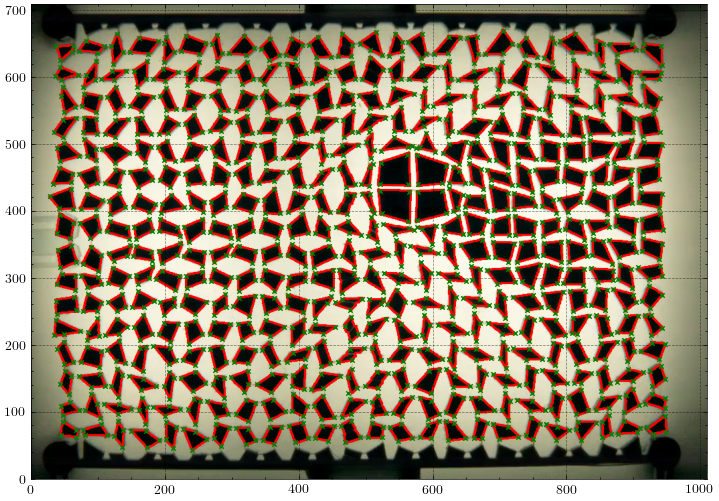

In [7]:
show_reference_frame(video_path=video_paths[0], frame=0)


In [8]:
# t = track_video(video_path=video_paths[4],
#                 plot_centroids=False, monitor_progress=True)


### Process videos in bulk

In [9]:
# # Filter the videos that we want to process
# all_videos = pd.DataFrame({
#     "label": [p.stem for p in video_paths],
#     "shaker_mode": [p.stem.split("_")[-6] for p in video_paths],
#     "compression": [float(p.stem.split("_")[-4]) for p in video_paths],
#     "voltage": [float(p.stem.split("_")[-3][:-2]) for p in video_paths],
#     "frequency": [float(p.stem.split("_")[-2][:-2]) for p in video_paths],
#     "path": video_paths,
# })
# videos_to_process = all_videos[
#         (all_videos["compression"] == 0.)
# ]

# # Track each video and save the tracked data
# for path in videos_to_process["path"]:
#     tracked_data = track_video(path)
#     save_data(f"{data_folder}/{design_name}/dynamic-data/tracking_exp/{path.stem}.pkl", tracked_data._asdict())


## Tracking: 1% compression


### Tracking helper functions


In [10]:
def compute_reference_simulation_data(compressive_strain):
    """Compute the reference simulation data for the tracked experiments."""
    return problem.solve(
        design_values,
        amplitude=optimization.forward_input.amplitude[0],
        loading_rate=optimization.forward_input.loading_rate[0],
        compressive_strain=compressive_strain,
        compressive_strain_rate=optimization.forward_input.compressive_strain_rate[0],
    )


def compute_initial_centroids_and_shapes(solution_data: SolutionData):
    """Compute the initial centroids and shapes of the tracked blocks."""
    initial_centroids = (solution_data.block_centroids +
                         solution_data.fields[0, 0, :, :2])[problem.moving_blocks_ids]
    initial_shapes = current_coordinates(
        solution_data.centroid_node_vectors,
        0*solution_data.block_centroids,
        solution_data.fields[0, 0, :, 2],
        0*solution_data.fields[0, 0, :, :2],
    )[problem.moving_blocks_ids]
    return initial_centroids, initial_shapes

In [11]:
# Define the tracked geometry i.e the reference geometry without clamped blocks using the simulated response under compressive strain
# Compression of 0.01 is saved already so no need to recompute
reference_simulation_data = problem.solution_data[0]
reference_centroids, reference_shapes = compute_initial_centroids_and_shapes(
    solution_data=reference_simulation_data
)


def morphological_transformation(thresh):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    transformed = cv2.morphologyEx(
        thresh, cv2.MORPH_ERODE, kernel, iterations=2)
    return transformed


def add_clamped_blocks_data(tracked_data: SolutionData) -> SolutionData:
    """Add the data for the clamped blocks to the tracked data (for easier comparison with simulations)."""
    # Add simulated compression step to the tracked data
    fields = jnp.zeros(
        (tracked_data.fields.shape[0], *reference_simulation_data.fields.shape[1:]))
    fields = fields.at[:, :, problem.moving_blocks_ids].set(
        tracked_data.fields)
    fields = fields.at[:, 0].add(reference_simulation_data.fields[0, 0])
    return reference_simulation_data._replace(
        fields=fields,
        timepoints=tracked_data.timepoints,
    )


# Marker placement parameters
marker_placement_params = dict(
    calib_xy=(0.395, 0.395),  # mm/px
    ROI_X=(155, 1165),
    ROI_Y=(5, 714),  # (5, 714),
    blur_size=1,
    threshold=52,  # 61,
    adaptive_thresholding=True,
    adaptive_thresholding_block=483,
    morphological_transformation=morphological_transformation,
    block_area=(10, 3500),
    reference_centroids=reference_centroids,
    reference_shapes=reference_shapes,
    aspect_ratio_threshold=0.05,
    # Place markers a little bit closer to the centroid to have better features for cross-correlation.
    markers_scaled_position=0.85,
    # masked_areas=[((225, 230), (314, 320))],
)
# Cross-correlation parameters
xcorr_params = dict(
    marker_template_size=20,  # px
    search_window_size=30,  # px
    upscaling_factor=5,
)


def show_reference_frame(video_path: Union[str, Path], frame: int = 0):
    markers, centroids = mark_reference_frame(
        video_path=str(video_path),
        **marker_placement_params,
        frame=frame,
        show=True,
    )
    print(f"Number of marked blocks: {len(markers)}")


def track_video(video_path: Union[str, Path], plot_centroids: bool = False, monitor_progress: bool = False):
    tracked_data = tracking(
        video_path=str(video_path),
        start_end_video=(50, 400),  # (0, 600),
        framerate=1000,
        **marker_placement_params,
        **xcorr_params,
        monitor_progress=monitor_progress,
        show_tracked_frame=False,
    )
    # Add the data for the clamped blocks
    tracked_data = add_clamped_blocks_data(tracked_data)
    # Shift timepoints to start at 0
    tracked_data = tracked_data._replace(
        timepoints=tracked_data.timepoints - tracked_data.timepoints[0])
    # Smooth the data with a Savitzky-Golay filter
    # tracked_data = tracked_data._replace(fields=smooth_fields_SG(
    #     tracked_data.fields, window_length=[[11, 11, 21], [11, 11, 21]], polyorder=3))

    if plot_centroids:
        # Plot centroids
        plt.figure(figsize=(8, 8*(geometry.n2_blocks+1) /
                   geometry.n1_blocks), constrained_layout=True)
        plt.title(r"Centroids - frame \#0")
        plt.scatter(*reference_centroids.T, label="Reference")
        plt.scatter(
            *tracked_data.block_centroids[problem.moving_blocks_ids].T, label="Tracked")
        plt.scatter(
            *tracked_data.block_centroids[problem.clamped_blocks_ids].T, label="Clamped")
        for i, pt in enumerate(tracked_data.block_centroids):
            plt.text(*pt, f"{i}")
        plt.axis("equal")
        plt.legend(bbox_to_anchor=(0.5, -0.08), loc='center', ncol=3)

    return tracked_data

### Process one video


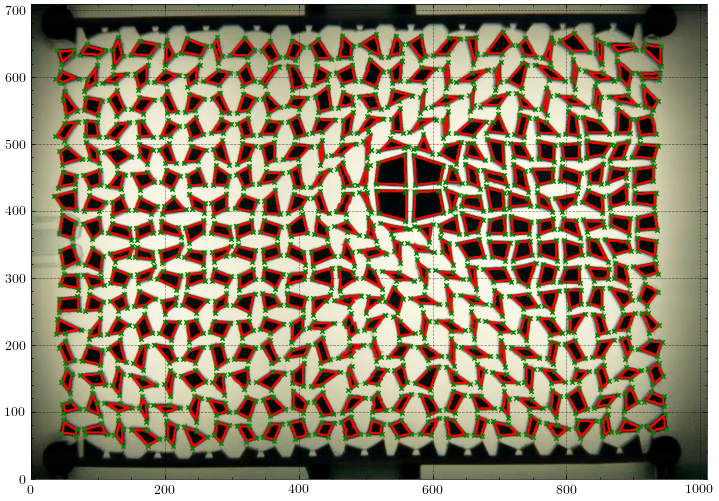

Number of marked blocks: 384


In [12]:
show_reference_frame(video_path=video_paths[4], frame=0)


In [13]:
# t = track_video(video_path=video_paths[8],
#                 plot_centroids=False, monitor_progress=True)


### Process videos in bulk


In [14]:
# # Filter the videos that we want to process
# all_videos = pd.DataFrame({
#     "label": [p.stem for p in video_paths],
#     "shaker_mode": [p.stem.split("_")[-6] for p in video_paths],
#     "compression": [float(p.stem.split("_")[-4]) for p in video_paths],
#     "voltage": [float(p.stem.split("_")[-3][:-2]) for p in video_paths],
#     "frequency": [float(p.stem.split("_")[-2][:-2]) for p in video_paths],
#     "path": video_paths,
# })
# videos_to_process = all_videos[
#         (all_videos["compression"] == 0.01)
# ]

# # Track each video and save the tracked data
# for path in videos_to_process["path"]:
#     tracked_data = track_video(path)
#     save_data(f"{data_folder}/{design_name}/dynamic-data/tracking_exp/{path.stem}.pkl", tracked_data._asdict())


## Tracking: 8% compression


### Tracking helper functions


In [15]:
def compute_reference_simulation_data(compressive_strain):
    """Compute the reference simulation data for the tracked experiments."""
    return problem.solve(
        design_values,
        amplitude=optimization.forward_input.amplitude[0],
        loading_rate=optimization.forward_input.loading_rate[0],
        compressive_strain=compressive_strain,
        compressive_strain_rate=optimization.forward_input.compressive_strain_rate[0],
    )


def compute_initial_centroids_and_shapes(solution_data: SolutionData):
    """Compute the initial centroids and shapes of the tracked blocks."""
    initial_centroids = (solution_data.block_centroids +
                         solution_data.fields[0, 0, :, :2])[problem.moving_blocks_ids]
    initial_shapes = current_coordinates(
        solution_data.centroid_node_vectors,
        0*solution_data.block_centroids,
        solution_data.fields[0, 0, :, 2],
        0*solution_data.fields[0, 0, :, :2],
    )[problem.moving_blocks_ids]
    return initial_centroids, initial_shapes

In [16]:
# Define the tracked geometry i.e the reference geometry without clamped blocks using the simulated response under compressive strain
# Compression of 0.08 is saved already so no need to recompute
reference_simulation_data = problem.solution_data[-1]
reference_centroids, reference_shapes = compute_initial_centroids_and_shapes(
    solution_data=reference_simulation_data
)


def morphological_transformation(thresh):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    transformed = cv2.morphologyEx(
        thresh, cv2.MORPH_ERODE, kernel, iterations=2)
    return transformed


def add_clamped_blocks_data(tracked_data: SolutionData) -> SolutionData:
    """Add the data for the clamped blocks to the tracked data (for easier comparison with simulations)."""
    # Add simulated compression step to the tracked data
    fields = jnp.zeros(
        (tracked_data.fields.shape[0], *reference_simulation_data.fields.shape[1:]))
    fields = fields.at[:, :, problem.moving_blocks_ids].set(
        tracked_data.fields)
    fields = reference_simulation_data.fields[0] + fields
    return reference_simulation_data._replace(
        fields=fields,
        timepoints=tracked_data.timepoints,
    )


# Marker placement parameters
marker_placement_params = dict(
    calib_xy=(0.395, 0.395),  # mm/px
    ROI_X=(155, 1165),
    ROI_Y=(35, 680),  # (5, 714),
    blur_size=1,
    threshold=50,  # 16,  # 61,
    adaptive_thresholding=True,
    adaptive_thresholding_block=333,
    morphological_transformation=morphological_transformation,
    block_area=(10, 3500),
    reference_centroids=reference_centroids,
    reference_shapes=reference_shapes,
    aspect_ratio_threshold=0.05,
    # Place markers a little bit closer to the centroid to have better features for cross-correlation.
    markers_scaled_position=0.8,
    masked_areas=[
        ((65, 70), (450, 454)),
        ((525, 530), (268, 271)),
        ((624, 627), (155, 157)),
        ((876, 879), (325, 328)),
        ((497, 500), (488, 490)),
        ((816, 819), (304, 307)),
    ],
)
# Cross-correlation parameters
xcorr_params = dict(
    marker_template_size=20,  # px
    search_window_size=30,  # px
    upscaling_factor=5,
)


def show_reference_frame(video_path: Union[str, Path], frame: int = 0):
    markers, centroids = mark_reference_frame(
        video_path=str(video_path),
        **marker_placement_params,
        frame=frame,
        show=True,
    )
    print(f"Number of marked blocks: {len(markers)}")


def track_video(video_path: Union[str, Path], plot_centroids: bool = False, monitor_progress: bool = False):
    tracked_data = tracking(
        video_path=str(video_path),
        start_end_video=(50, 400),  # (0, 600),
        framerate=1000,
        **marker_placement_params,
        **xcorr_params,
        monitor_progress=monitor_progress,
        show_tracked_frame=False,
    )
    # Add the data for the clamped blocks
    tracked_data = add_clamped_blocks_data(tracked_data)
    # Shift timepoints to start at 0
    tracked_data = tracked_data._replace(
        timepoints=tracked_data.timepoints - tracked_data.timepoints[0])
    # Smooth the data with a Savitzky-Golay filter
    # tracked_data = tracked_data._replace(fields=smooth_fields_SG(
    #     tracked_data.fields, window_length=[[11, 11, 21], [11, 11, 21]], polyorder=3))

    if plot_centroids:
        # Plot centroids
        plt.figure(figsize=(8, 8*(geometry.n2_blocks+1) /
                   geometry.n1_blocks), constrained_layout=True)
        plt.title(r"Centroids - frame \#0")
        plt.scatter(*reference_centroids.T, label="Reference")
        plt.scatter(
            *tracked_data.block_centroids[problem.moving_blocks_ids].T, label="Tracked")
        plt.scatter(
            *tracked_data.block_centroids[problem.clamped_blocks_ids].T, label="Clamped")
        for i, pt in enumerate(tracked_data.block_centroids):
            plt.text(*pt, f"{i}")
        plt.axis("equal")
        plt.legend(bbox_to_anchor=(0.5, -0.08), loc='center', ncol=3)

    return tracked_data

### Process one video


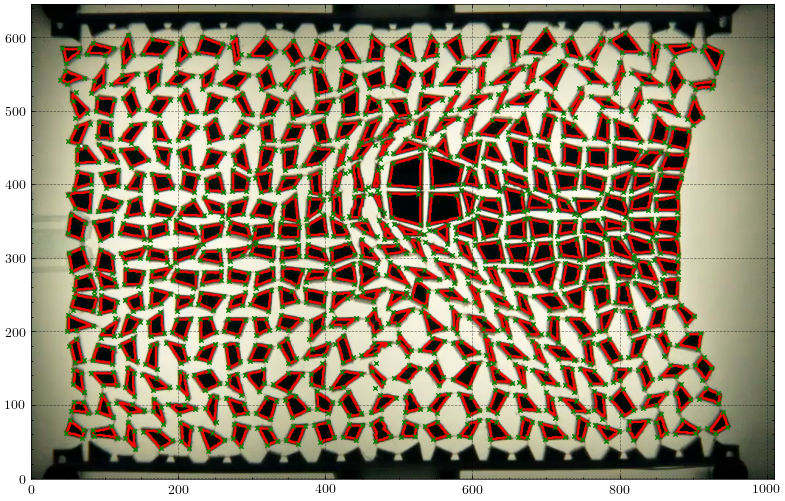

Number of marked blocks: 384


In [25]:
show_reference_frame(video_path=video_paths[-1], frame=0)


In [18]:
# t = track_video(video_path=video_paths[-3],
#                 plot_centroids=False, monitor_progress=True)


### Process videos in bulk


In [19]:
# # Filter the videos that we want to process
# all_videos = pd.DataFrame({
#     "label": [p.stem for p in video_paths],
#     "shaker_mode": [p.stem.split("_")[-6] for p in video_paths],
#     "compression": [float(p.stem.split("_")[-4]) for p in video_paths],
#     "voltage": [float(p.stem.split("_")[-3][:-2]) for p in video_paths],
#     "frequency": [float(p.stem.split("_")[-2][:-2]) for p in video_paths],
#     "path": video_paths,
# })
# videos_to_process = all_videos[
#         (all_videos["compression"] == 0.08)
# ]

# # Track each video and save the tracked data
# for path in videos_to_process["path"]:
#     tracked_data = track_video(path)
#     save_data(f"{data_folder}/{design_name}/dynamic-data/tracking_exp/{path.stem}.pkl", tracked_data._asdict())


## Load tracking data


In [20]:
# Find all data files in the dynamic-data folder
tracked_data_paths = sorted(list(Path(
    f"{data_folder}/{design_name}/dynamic-data/tracking_exp/").glob("*.pkl")), key=lambda p: p.stem[-3:])

# Load the tracked data as a dataframe
# NOTE: Make sure the filenames are consistent as voltages and frequencies are extracted from the filenames.
tracked_data = pd.DataFrame({
    "label": [p.stem for p in tracked_data_paths],
    "shaker_mode": [p.stem.split("_")[-6] for p in tracked_data_paths],
    "compression": [float(p.stem.split("_")[-4]) for p in tracked_data_paths],
    "voltage": [float(p.stem.split("_")[-3][:-2]) for p in tracked_data_paths],
    "frequency": [float(p.stem.split("_")[-2][:-2]) for p in tracked_data_paths],
    "data": [SolutionData(**load_data(p)) for p in tracked_data_paths],
})

excited_blocks_ids = problem.driven_blocks_ids
# Smooth tracking data
tracked_data.data = tracked_data.apply(
    lambda row: row.data._replace(fields=smooth_fields_SG(
        row.data.fields, window_length=[[11, 11, 19], [21, 21, 25]], polyorder=2)),
    axis=1,
)
tracked_data

label shaker_mode  \
0   exp_shaker_burst_compression_0.00_100mV_30Hz_F162       burst   
1   exp_shaker_burst_compression_0.00_200mV_30Hz_F163       burst   
2   exp_shaker_burst_compression_0.00_300mV_30Hz_F164       burst   
3   exp_shaker_burst_compression_0.00_400mV_30Hz_F165       burst   
4   exp_shaker_burst_compression_0.01_100mV_30Hz_F171       burst   
5   exp_shaker_burst_compression_0.01_200mV_30Hz_F172       burst   
6   exp_shaker_burst_compression_0.01_300mV_30Hz_F173       burst   
7   exp_shaker_burst_compression_0.01_400mV_30Hz_F174       burst   
8   exp_shaker_burst_compression_0.08_100mV_30Hz_F175       burst   
9   exp_shaker_burst_compression_0.08_200mV_30Hz_F176       burst   
10  exp_shaker_burst_compression_0.08_300mV_30Hz_F177       burst   
11  exp_shaker_burst_compression_0.08_400mV_30Hz_F178       burst   
12  exp_shaker_burst_compression_0.08_500mV_30Hz_F179       burst   

    compression  voltage  frequency  \
0          0.00    100.0       30.0   
1          0.00    200.0       30.0   
2          0.00    300.0       30.0   
3          0.00    400.0       30.0   
4          0.01    100.0       30.0   
5          0.01    200.0       30.0   
6          0.01    300.0       30.0   
7          0.01    400.0       30.0   
8          0.08    100.0       30.0   
9          0.08    200.0       30.0   
10         0.08    300.0       30.0   
11         0.08    400.0       30.0   
12         0.08    500.0       30.0   

                                                 data  
0   ([[0.6129194328834726, 0.9305536807769724], [1...  
1   ([[0.6129194328834726, 0.9305536807769724], [1...  
2   ([[0.6129194328834726, 0.9305536807769724], [1...  
3   ([[0.6129194328834726, 0.9305536807769724], [1...  
4   ([[0.6129194328834726, 0.9305536807769724], [1...  
5   ([[0.6129194328834726, 0.9305536807769724], [1...  
6   ([[0.6129194328834726, 0.9305536807769724], [1...  
7   ([[0.6129194328834726, 0.9305536807769724], [1...  
8   ([[0.6129194328834726, 0.9305536807769724], [1...  
9   ([[0.6129194328834726, 0.9305536807769724], [1...  
10  ([[0.6129194328834726, 0.9305536807769724], [1...  
11  ([[0.6129194328834726, 0.9305536807769724], [1...  
12  ([[0.6129194328834726, 0.9305536807769724], [1...

### Plot input signals


In [ ]:
def plot_shaker_input(tracked_data, DOF=0):
    fig, axes = plt.subplots(figsize=(7, 3), constrained_layout=True)

    for row in tracked_data.itertuples():
        axes.plot(
            row.data.timepoints,
            row.data.fields[:, 0, excited_blocks_ids[0], DOF],
            label=f"{row.label.split('_')[-1]}: {row.voltage:.0f}mV, {row.frequency:.0f}Hz",
            lw=2,
        )

    axes.axhline(0, color="black", ls="-", lw=1)
    axes.set(xlabel="Time [s]", ylabel="Displacement [mm]")
    axes.set(title=f"Shaker input - DOF {DOF}")
    axes.legend(loc='upper right')
    return fig, axes


In [ ]:
plot_shaker_input(
    tracked_data[tracked_data.compression == 0.0],
    DOF=0
)

In [ ]:
plot_shaker_input(
    tracked_data[tracked_data.compression == 0.01],
    DOF=0
)

In [ ]:
plot_shaker_input(
    tracked_data[tracked_data.compression == 0.08],
    DOF=0
)

### Animation of tracked experiments


In [ ]:
# Animation tracked experiments
xlim, ylim = problem.geometry.get_xy_limits(
    *design_values) + 0.5*problem.geometry.spacing * jnp.array([-1, 1])

for row in tracked_data.itertuples():
    generate_animation(
        row.data,
        frame_range=jnp.arange(0, row.data.timepoints.shape[0], 2),
        field="u",
        deformed=True,
        out_filename=f"{out_folder}/{optimization_filename}/tracking_exp/{row.label}",
        xlim=xlim,
        ylim=ylim,
        figsize=(8, 5),
        fps=30,
        dpi=300,
        cmap="inferno",
        grid=False,
    )